In [1]:
# AIRE


In [2]:
import gpsea
from gpsea.analysis.predicate import PatientCategories
from gpsea.preprocessing import load_phenopackets
from gpsea.preprocessing import configure_caching_cohort_creator
from gpsea.model import FeatureType, VariantEffect
from gpsea.view import CohortViewable
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer
import hpotk
from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.2.dev0


In [3]:
gene_symbol = 'AIRE'
mane_tx_id = 'NM_000383.4'
mane_protein_id = 'NP_000374.1' # autoimmune regulator

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator

cohort_name = gene_symbol

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.20') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 17/17 [00:00<00:00, 2536.58individuals/s]
Validated under permissive policy
No errors or warnings were found


In [5]:
cv = CohortViewable(hpo=hpo)
print(type(cohort))
report = cv.process(cohort=cohort, transcript_id=mane_tx_id);
report

<class 'gpsea.model._cohort.Cohort'>


HPO Term,ID,Seen in n individuals
Hypoparathyroidism,HP:0000829,17
Recurrent fungal infections,HP:0002841,14
Primary adrenal insufficiency,HP:0008207,8
Chronic active hepatitis,HP:0200120,6
Keratoconjunctivitis,HP:0001096,5
Premature ovarian insufficiency,HP:0008209,3
Malabsorption,HP:0002024,3
Alopecia,HP:0001596,3
Cataract,HP:0000518,2
Pancreatitis,HP:0001733,1


In [6]:
from gpsea.preprocessing import configure_protein_metadata_service

pms = configure_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
# TODO: Check Genome Build
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)
pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_84017/3724131582.py:3: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


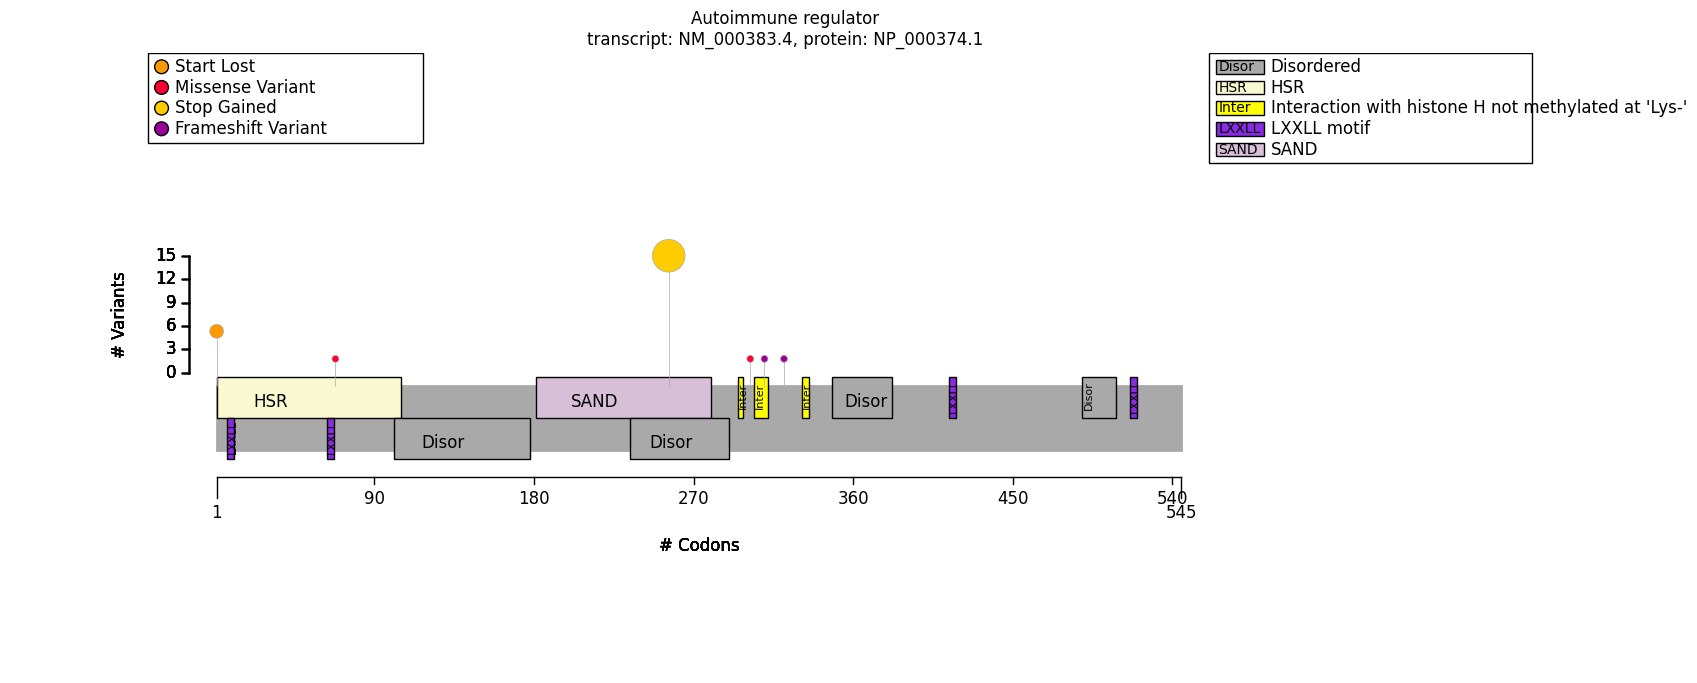

In [7]:
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis);

In [8]:
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
    term_frequency_threshold=0.001,
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

In [9]:
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

In [13]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
from gpsea.model import VariantEffect
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant, autosomal_recessive


gt_predicate = autosomal_recessive(partitions={(1,), (2,)})
gt_predicate.display_question()



'What is the genotype group: Monoallelic, Biallelic'

In [11]:

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
report = viewer.process(result)
report

Code,Reason,Count
HMF02,Skipping term because no genotype has more than one observed HPO count,1
HMF04,Skipping term because all genotypes have same HPO observed proportions,6
HMF06,Skipping term with less than 7 observations (not powered for 2x2),22
HMF08,Skipping general term,30


In [12]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

What is the genotype group                 Monoallelic         Biallelic  \
                                                 Count Percent     Count   
Recurrent fungal infections [HP:0002841]           2/3     67%     12/12   
Primary adrenal insufficiency [HP:0008207]         1/3     33%      7/13   

What is the genotype group                                                      
                                           Percent Corrected p values p values  
Recurrent fungal infections [HP:0002841]      100%                0.4      0.2  
Primary adrenal insufficiency [HP:0008207]     54%                1.0      1.0